In [1]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt
import json,copy

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White, Addition
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [4]:
def printSample(sample,depth=1):
    keys = sample.keys()
    keys.sort()
    
    for k in keys:
        if type(sample[k]) == dict:
            print "\t".join([""]*depth) + k
            printSample(sample[k],depth=depth+1)
        else:
            print "\t".join([""]*depth) + "%s: %s"%(k,str(sample[k]))

In [29]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well'])
y = np.log2(y)

ymean,ystd = y.mean(),y.std()
y = (y-y.mean())/y.std()

In [6]:
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)
edge

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 121, 131,
       141, 151, 161, 171, 181, 120, 130, 140, 150, 160, 170, 180, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 221, 231, 241, 251, 261,
       271, 281, 220, 230, 240, 250, 260, 270, 280, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300])

In [7]:
dist = np.array([min(abs(l-edge)) for l in labels[0]])
position = (dist==0).astype(int)

In [32]:
yKernel = Addition(White(1,.1),RBF(1,.1))
k1 = RBF(1,1,1)
k2 = RBF(1,1,.1)

p = y.shape[1]
dm = np.ones((2,p))
dm[1,:] = 1-2*position

prior = Prior(x,k1,[0])
prior2 = Prior(x,k2,range(1,dm.shape[0]))

model = Model(x,y,dm)

In [33]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,k1_sigma=x),
                    lambda x: scipy.stats.uniform(1e-6,1e2).logpdf(x),
                    .2,5,logspace=True)

ySigma2Slice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,k2_sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

yLengthscaleSlice = Slice('yLengthscale',
                    lambda x: model.dataLikelihood(yKernel,k2_lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)


kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-6,1e2).logpdf(x),
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-1,1e2).logpdf(x),
                    .2,5,logspace=True)

k2SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-6,1e2).logpdf(x),
                    .2,5,logspace=True)

k2LengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior2.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-1,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,k2=k2,model=model)

In [34]:
thin = 10
burnin = 0
nsample = 3000

for i in range(nsample):
    prior.sample(model,yKernel)
    prior2.sample(model,yKernel)
    
    yKernel.k1.sigma = ySigmaSlice.sample(yKernel.k1.sigma)
    yKernel.k2.sigma = ySigma2Slice.sample(yKernel.k2.sigma)
    yKernel.k2.lengthscale = yLengthscaleSlice.sample(yKernel.k2.lengthscale)
    
    k1.sigma = kSigmaSlice.sample(k1.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)
    
    k2.sigma = k2SigmaSlice.sample(k2.sigma)
    k2.lengthscale = k2LengthscaleSlice.sample(k2.lengthscale)

    if i % thin == 0 and i > burnin:
        f = freeze.freeze()
        del f['model']
        
        print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        print model.dataLikelihood(yKernel)
        printSample(f)
        print
        
        samples.append(freeze.freeze())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
22001.0092607
k1
	lengthscale: 0.123240726794
	sigma: 0.0828615649743
k2
	lengthscale: 0.130361512663
	sigma: 0.0264904188218
yKernel
	k1
		sigma: 0.00738146994766
	k2
		lengthscale: 0.198506533824
		sigma: 0.027309853538

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
30544.8796083
k1
	lengthscale: 0.10018606479
	sigma: 0.0320882709838
k2
	lengthscale: 0.100580847583
	sigma: 0.0515719894424
yKernel
	k1
		sigma: 0.000880072652757
	k2
		lengthscale: 0.118245758912
		sigma: 0.0184137137625

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
30578.1070637
k1
	lengthscale: 0.100221757973
	sigma: 0.0383818367436
k2
	lengthscale: 0.100263922974
	sigma: 0.0391733004859
yKernel
	k1
		sigma: 0.000943194215285
	k2
		lengthscale: 0.124042663722
		sigma: 0.0213863765077

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
30580.9011842
k1
	lengthscale: 0.100109174834
	sigma: 0.0320420908973
k2
	lengthscale: 0.100071299928
	sigma: 0.0386032041497
yKernel
	k1
		sigma: 0.000932072873541
	k2

In [50]:
samples = json.load(open("edgeEffect-edge-replicate.json"))

for s in samples:
    s['model']['beta'] = np.array(s['model']['beta'])

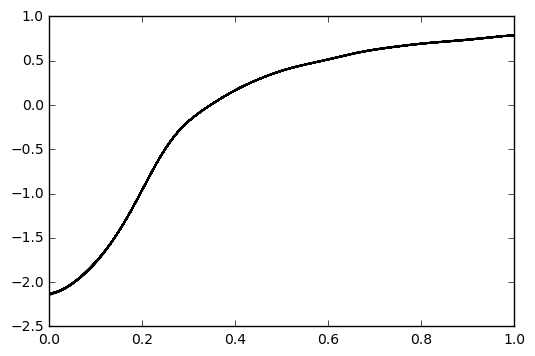

In [51]:
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='k',alpha=.5);

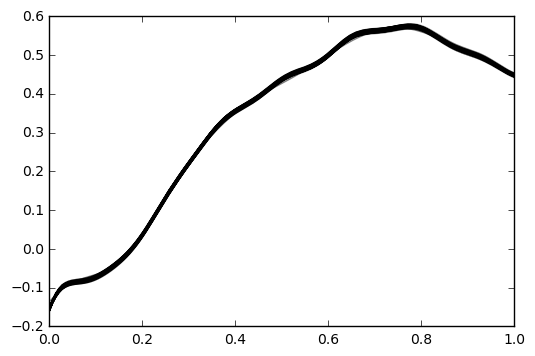

In [52]:
plt.plot(x,np.array([2*s['model']['beta'][:,1] for s in samples]).T,c='k',alpha=.5);

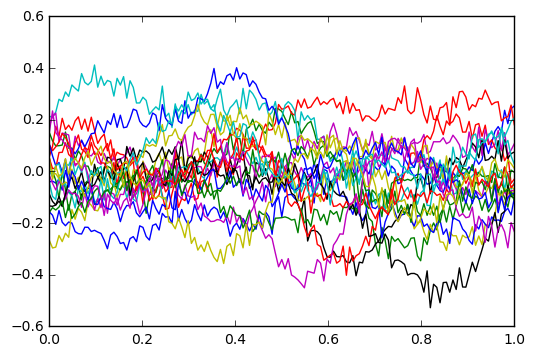

In [37]:
plt.plot(x,scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),yKernel.K(x),size=20).T);

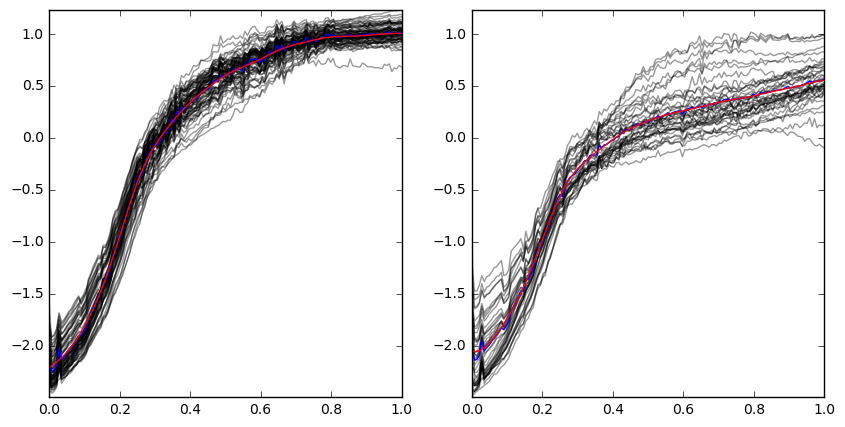

In [38]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,5))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(1,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='b',alpha=1)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    
    plt.ylim(y.min(),y.max())

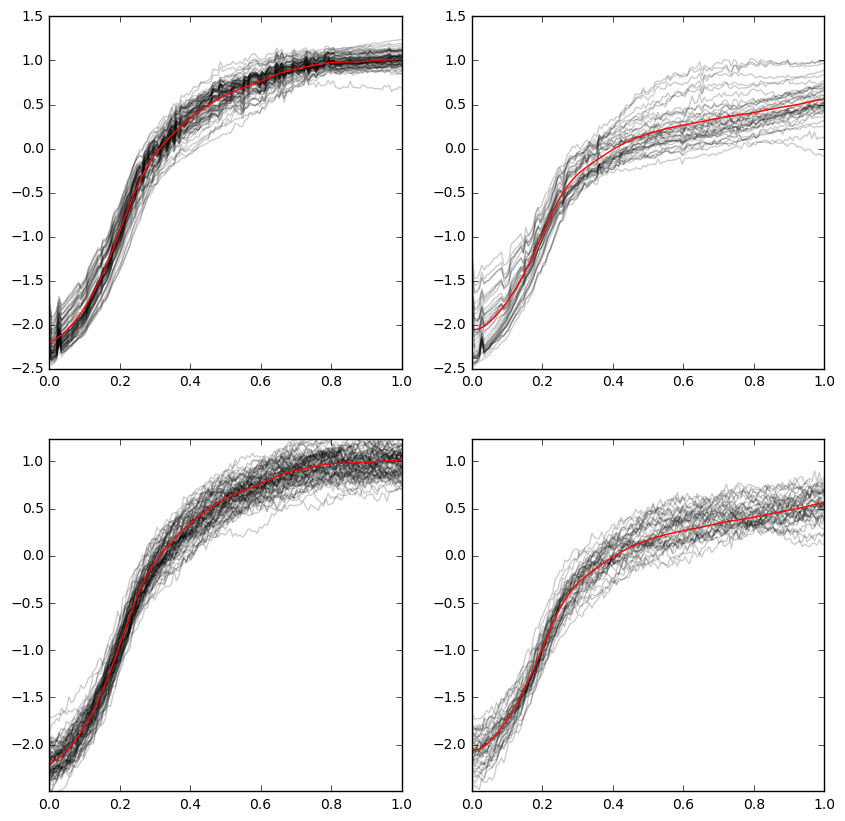

In [39]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,10))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(2,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.2)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    
    plt.subplot(2,2,i+3)
    sample = scipy.stats.multivariate_normal.rvs(beta[:,0] + (1-2*p)*beta[:,1],yKernel.K(x),size=sum(select)).T
    plt.plot(x,sample,c='k',alpha=.2)
    plt.plot(x,beta[:,0] + (1-2*p)*beta[:,1],c='r')
    plt.ylim(y.min(),y.max())

In [54]:
samplesCopy = [copy.deepcopy(s) for s in samples]
for s in samplesCopy:
    s['model']['beta'] = s['model']['beta'].tolist()
    
s = json.dumps(samplesCopy)

ofile = open("edgeEffect-edge-replicate.json",'w')
ofile.write(s)
ofile.close()